In [1]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.ndimage import binary_erosion, binary_dilation
from mpl_toolkits.mplot3d import Axes3D
import cv2 as cv
import imageio

if torch.cuda.is_available():
    # Get the number of available GPUs
    gpu_count = torch.cuda.device_count()
    print(f"Number of available GPUs: {gpu_count}")

    # Iterate over each GPU and display its properties
    for i in range(gpu_count):
        gpu_properties = torch.cuda.get_device_properties(i)
        print(f"GPU {i} Properties:")
        print(f"\tName: {gpu_properties.name}")
        print(f"\tTotal Memory: {gpu_properties.total_memory / 1024**3:.2f} GB")
        print(f"\tCUDA Capability: {gpu_properties.major}.{gpu_properties.minor}")
        print(f"\tMulti-Processor Count: {gpu_properties.multi_processor_count}")
else:
    print("No GPU available, using CPU instead.")


Number of available GPUs: 1
GPU 0 Properties:
	Name: NVIDIA GeForce RTX 3070 Ti Laptop GPU
	Total Memory: 8.00 GB
	CUDA Capability: 8.6
	Multi-Processor Count: 46


/tmp/ipykernel_201/2382707627.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  B = imageio.imread(Brightfield)


(20, 684, 856)
Type of brighfield image: <class 'numpy.ndarray'>
Pre Porcessed Shape: (684, 428, 3)


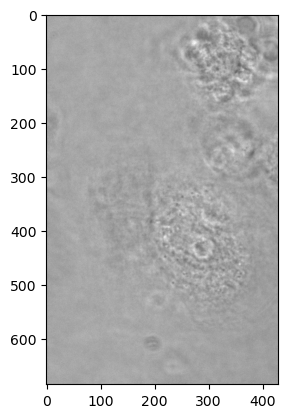

In [2]:


BaseFolder = '../datasets/'
filename = BaseFolder + 'EGFR_Steps_1.csv'
Brightfield = BaseFolder + "MDA-MB-468_4-colour_EGF_B10_1nM_posXY0_channels_t0_posZ0_colour0.tif"

# Plot Image
B = imageio.imread(Brightfield)

print(B.shape)

# Assuming im1 and im2 are your images

# Extracting one frame from im2
frame = B[3, :, :]

# Cropping the frame to match the width of im1
bf_ndarray = frame[:, :428]

print("Type of brighfield image:", type(bf_ndarray))


# Normalize image if the values are outside the typical 8-bit range
if bf_ndarray.max() > 255:
    bf_ndarray = (bf_ndarray / bf_ndarray.max() * 255).astype(np.uint8)
# Convert single channel to multichannel (RGB)
gs_ndarray = np.stack((bf_ndarray,) * 3, axis=-1)
print("Pre Porcessed Shape:", gs_ndarray.shape)

plt.figure()
plt.imshow(gs_ndarray)
plt.show()


# Testing Functions
def scale_tensor_to_range(tensor, new_min=-1., new_max=1.):
  """
  Scales a PyTorch tensor to a new range between new_min and new_max (inclusive).

  Args:
      tensor: The input tensor to be scaled.
      new_min: The minimum value in the new range (default: -1.0).
      new_max: The maximum value in the new range (default: 1.0).

  Returns:
      A new tensor with the same shape as the input tensor, but with values scaled
      to the new range.
  """

  # Get the current minimum and maximum values of the tensor
  current_min = tensor.min()
  current_max = tensor.max()

  # Calculate the scaling factor
  if current_min != current_max:  # Avoid division by zero if all elements are the same
    scaling_factor = (new_max - new_min) / (current_max - current_min)
  else:
    scaling_factor = 1.0  # If all elements are the same, use a factor of 1 to avoid NaN

  # Apply the scaling factor to the tensor
  scaled_tensor = (tensor - current_min) * scaling_factor + new_min

  return scaled_tensor

def print_tensor(scaled_tensor):
    plt.figure()
    plt.imshow(scaled_tensor)
    plt.show()

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Define a simple CNN with one Conv2D layer
class MaskLayer(nn.Module):
    def __init__(self, input_shape, in_channels, out_channels):
        super(MaskLayer, self).__init__()

        # Params
        self.input_shape = input_shape
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        # Define a Conv2D layer
        self.kernel_size_conv = 3
        self.kernel_size_maxp = 5

        # Convolution Layers
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)

        # MaxPool Layers
        self.max_pool_1 = nn.MaxPool2d(32, stride=None, padding=0,return_indices=True)

        # Batch Norm Layer
        self.batch_norm_1 = nn.BatchNorm2d(32)


        # utils
        self.mask = None
        self.mask_indices = None
        
    
    def forward(self, x):
        # Apply the Conv2D layer
        x = self.conv1(x)
        x, pool_indices = self.max_pool_1(x)
        x = self.batch_norm_1(x)
        return x, pool_indices

    def plot_tensor(tensor, title, num_channels=3):
        # Detach the tensor from the graph and convert it to a numpy array
        tensor = tensor.detach().numpy()
        
        # Plot each channel separately
        fig, axes = plt.subplots(1, num_channels, figsize=(15, 5))
        if num_channels == 1:
            axes = [axes]  # Ensure axes is iterable if there is only one channel
        for i in range(num_channels):
            axes[i].imshow(tensor[0, i, :, :], cmap='gray')
            axes[i].set_title(f"{title} - Channel {i+1}")
            axes[i].axis('off')
        plt.show()

    def scale_tensor_to_range(tensor, new_min=-1., new_max=1.):
      """
      Scales a PyTorch tensor to a new range between new_min and new_max (inclusive).
    
      Args:
          tensor: The input tensor to be scaled.
          new_min: The minimum value in the new range (default: -1.0).
          new_max: The maximum value in the new range (default: 1.0).
    
      Returns:
          A new tensor with the same shape as the input tensor, but with values scaled
          to the new range.
      """
    
      # Get the current minimum and maximum values of the tensor
      current_min = tensor.min()
      current_max = tensor.max()
    
      # Calculate the scaling factor
      if current_min != current_max:  # Avoid division by zero if all elements are the same
        scaling_factor = (new_max - new_min) / (current_max - current_min)
      else:
        scaling_factor = 1.0  # If all elements are the same, use a factor of 1 to avoid NaN
    
      # Apply the scaling factor to the tensor
      scaled_tensor = (tensor - current_min) * scaling_factor + new_min
      return scaled_tensor

    def create_mask(tensor):
        self.mask = np.where(tensor.detach().numpy() < -0.4, -1, 1)

    def create_indices(self):
        self.mask_indices = np.where(mask.detach().numpy() == 1)
    
    # Mask Channel
    def mask_channel(self, channel):
        temp = channel.detach().numpy()
        temp = np.where(temp < -0.4, 1, 0).astype(np.float32)
        
        return torch.from_numpy(temp)
        
    def get_mask(self): 
        return self.mask

    def get_mask_indices(self):
        return self.mask_indices


class CheckeredPatternRemover(nn.Module):
    def __init__(self, input_shape, in_channels, out_channels):
        super(CheckeredPatternRemover, self).__init__()

        # Params
        self.input_shape = input_shape
        self.in_channels = in_channels
        self.out_channels = out_channels
        # Define a convolutional layer to smooth the image
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        # Initialize with an averaging kernel
        nn.init.constant_(self.conv.weight, 1.0 / 9)
        nn.init.constant_(self.conv.bias, 0)

    def forward(self, x):
        x = self.conv(x)
        return x






In [9]:
class ROI_Generation_Layer(nn.Module):
    def __init__(self, input_shape, in_channels, out_channels, threshold):
        super(ROI_Generation_Layer, self).__init__()

        # Params
        self.input_shape = input_shape
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.threshold = threshold
        # Models
        self.mask_layer = MaskLayer(input_shape,in_channels,out_channels)
        self.checker_pattern_remover = CheckeredPatternRemover(input_shape,in_channels,out_channels)

        #Extra usefull layers
        self.upscaler =  nn.ConvTranspose2d(in_channels=out_channels, out_channels=in_channels, kernel_size=2, stride=2, padding=0)
        self.max_unpool2D = torch.nn.MaxUnpool2d(1, stride=None, padding=0)
        self.dropout = nn.Dropout2d(p=0.3)

        # Tensors
        self.current_tensor_binary_mask = None
        self.current_tensor_cleaned_mask = None
        self.current_tensor_mask = None
        self.current_tensor_mask_upscaled = None
        self.tmp = None
    def forward(self, x):
        # Mask the image
        output_tensor, pool_indices = self.mask_layer(x)
        mask = output_tensor.clone()

        output_tensor = self.add_channels_(output_tensor)
        
        # Unbind the tensor into a list of channels
        channels = torch.unbind(output_tensor, dim=1)
        # Map each channel to a transform
        processed_channels = [self.mask_channel(channel) for channel in channels]
        
        # Stack the processed channels back into a single tensor
        masked_output_tensor = torch.stack(processed_channels, dim=1)
        tmp = masked_output_tensor.clone()
        
        # Upsace the mask
        upscaled_output_channel = self.upscaler(masked_output_tensor)
        #upscaled_output_channel = self.dropout(upscaled_output_channel)

        # Smoothen the mask
        smoothed_tensor = self.checker_pattern_remover(upscaled_output_channel)

        # Unbind the tensor into a list of channels
        smoothed_tensor_channels = torch.unbind(smoothed_tensor, dim=1)
        # Map each channel to a transform
        processed_channels_smoothed_tensor = [self.scale_tensor_to_range(channel,-1,0) for channel in smoothed_tensor_channels]
        
        # Stack the processed channels back into a single tensor
        smoothed_tensor = torch.stack(processed_channels_smoothed_tensor, dim=1)
        
        # Convert the smoothed tensor to a binary mask
        binary_mask = (smoothed_tensor > self.threshold).float()

        # Apply morphological opening to the binary mask
        cleaned_mask = torch.empty_like(binary_mask)
        for i in range(binary_mask.shape[1]):  # Apply on each channel separately
            cleaned_mask[0, i, :, :] = self.morphological_openings(binary_mask[0, i, :, :], structure_size=3)

        self.set_masks(mask,binary_mask,cleaned_mask, upscaled_output_channel,smoothed_tensor)
        
        return cleaned_mask, binary_mask, smoothed_tensor

    # Set computed masks for furhter use
    def set_masks(self, current, binary, cleaned, upscaled,tmp):
        self.current_tensor_mask = current
        self.current_tensor_cleaned_mask = cleaned
        self.current_tensor_binary_mask = binary
        self.current_tensor_mask_upscaled = upscaled
        self.tmp = tmp
        
    # Plot the current set of masks   
    def plot_masks(self, input_tensor):
        self.plot_tensor(input_tensor, "Input Tensor")
        self.plot_tensor(self.current_tensor_mask, "Downsample Mask")
        self.plot_tensor(self.tmp, "Tmp Mask")
        self.plot_tensor(self.current_tensor_mask_upscaled, "Upscaled Mask")
        self.plot_tensor(self.current_tensor_binary_mask, "Binary Mask")
        self.plot_tensor(self.current_tensor_cleaned_mask, "Cleaned Binary Mask")
    
    # Mask Channel
    def mask_channel(self,channel):
        temp = channel.detach().numpy()
        temp = np.where(temp < -0.4, 1, 0).astype(np.float32)
        #temp = self.update_array(temp)
        return torch.from_numpy(temp)

    # Define a function to apply morphological opening to remove noise
    def morphological_openings(self,mask, structure_size=3):
        structure = np.ones((structure_size, structure_size), dtype=bool)
        mask_np = mask.numpy().astype(bool)
    
        # Erosion
        eroded = binary_erosion(mask_np, structure=structure)
        # Dilation
        opened = binary_dilation(eroded, structure=structure)
    
        return torch.tensor(opened, dtype=torch.float32)

    def plot_tensor_info(self):
        print("Shape smooth tensor: ", smoothed_tensor.shape)
        print("Smooth tensor values:", smoothed_tensor)
        print("Smooth tensor Min:", smoothed_tensor.min())
        print("Smooth tensor Max:", smoothed_tensor.max())
    # Function to plot the images
    def plot_tensor(self,tensor, title=None, num_channels=3):
        # Detach the tensor from the graph and convert it to a numpy array
        tensor = tensor.detach().numpy()
        
        # Plot each channel separately
        fig, axes = plt.subplots(1, num_channels, figsize=(15, 5))
        if num_channels == 1:
            axes = [axes]  # Ensure axes is iterable if there is only one channel
        for i in range(num_channels):
            axes[i].imshow(tensor[0, i, :, :], cmap='gray')
            axes[i].set_title(f"{title} - Channel {i+1}")
            axes[i].axis('off')
        plt.show()

    # Get the neighbours of each element
    def get_neighbours(arr, x, y):
        rows, cols = range(len(arr)), range(len(arr[0]))
        offsets = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
        result = []
        for dy, dx in offsets:
            ny, nx = y + dy, x + dx
            if ny in cols and nx in rows:
                result.append(arr[nx, ny])
        return result

    # Update array by removing the noisy pixels
    def update_array(arr):
        updated_arr = np.copy(arr)  # Create a copy of the array to store the updated values
        rows, cols = arr.shape
    
        for i in range(rows):  # Iterate over rows
            for j in range(cols):  # Iterate over columns
                neighbors = self.get_neighbours(arr, i, j)
                if all(n == 1 for n in neighbors):  # Check if surrounded by -1
                    updated_arr[i, j] = 1
                elif sum(neighbors) >= -len(neighbors) + 1:
                    updated_arr[i, j] = 1
                else: updated_arr[i, j] = 0
                if sum(neighbors)>0:
                    updated_arr[i, j] = 0
                
                
        return updated_arr

    def map_tensor(self,input_tensor, func):
        # Unbind the tensor into a list of channels
        channels = torch.unbind(input_tensor, dim=1)
        # Map each channel to a transform
        processed_channels = [func(channel) for channel in channels]
        
        # Stack the processed channels back into a single tensor
        return torch.stack(processed_channels, dim=1)

    def add_channels_(self,tensor):
        """
        Takes an input tensor of shape (1, 3, x, y) and for each pixel,
        sums up the values of all 3 channels and adds the sum to each channel.
    
        Parameters:
        tensor: torch.Tensor of shape (1, 3, x, y)
    
        Returns:
        new_tensor: torch.Tensor of shape (1, 3, x, y)
        """
        # Sum the values of the 3 channels for each pixel
        channel_sum = tensor.sum(dim=1, keepdim=True)  # shape will be (1, 1, x, y)
    
        zeros = torch.zeros(tensor.shape[0], tensor.shape[1], tensor.shape[2], tensor.shape[3])
        # Add the sum to each channel
        new_tensor = zeros + channel_sum
        
        return new_tensor

    def scale_tensor_to_range(self,tensor, new_min=-1., new_max=1.):
      """
      Scales a PyTorch tensor to a new range between new_min and new_max (inclusive).
    
      Args:
          tensor: The input tensor to be scaled.
          new_min: The minimum value in the new range (default: -1.0).
          new_max: The maximum value in the new range (default: 1.0).
    
      Returns:
          A new tensor with the same shape as the input tensor, but with values scaled
          to the new range.
      """
    
      # Get the current minimum and maximum values of the tensor
      current_min = tensor.min()
      current_max = tensor.max()
    
      # Calculate the scaling factor
      if current_min != current_max:  # Avoid division by zero if all elements are the same
        scaling_factor = (new_max - new_min) / (current_max - current_min)
      else:
        scaling_factor = 1.0  # If all elements are the same, use a factor of 1 to avoid NaN
    
      # Apply the scaling factor to the tensor
      scaled_tensor = (tensor - current_min) * scaling_factor + new_min
    
      return scaled_tensor

In [5]:
# Function to plot each channel in 3D
def plot_tensor_channels_3d(tensor, title):
    channels, height, width = tensor.shape

    fig = plt.figure(figsize=(18, 6))
    
    for c in range(channels):
        ax = fig.add_subplot(1, channels, c + 1, projection='3d')
        X, Y = torch.meshgrid(torch.arange(height), torch.arange(width))
        Z = tensor[c].detach().numpy()
        
        ax.plot_surface(X.numpy(), Y.numpy(), Z, cmap='viridis')
        ax.set_title(f'{title}: channel {c + 1}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Pixel Value (Z)')
        
    plt.show()



Cleaned Mask Shape:  torch.Size([1, 3, 42, 26])   <class 'torch.Tensor'>
Binary Mask Shape:  torch.Size([1, 3, 42, 26])   <class 'torch.Tensor'>
Smoothed Mask Shape:  torch.Size([1, 3, 42, 26])   <class 'torch.Tensor'>


Shape smooth tensor:  torch.Size([1, 3, 42, 26])
Smooth tensor values: tensor([[[[ 0.0000, -0.0591, -0.0591,  ..., -0.0591, -0.0591,  0.0000],
          [-0.0591, -0.2902, -0.3332,  ..., -0.1477, -0.1477, -0.0591],
          [-0.0591, -0.3806, -0.4390,  ..., -0.1477, -0.1477, -0.0591],
          ...,
          [-0.0591, -0.5231, -0.6246,  ..., -1.0000, -0.7262, -0.5360],
          [-0.0591, -0.4709, -0.5448,  ..., -0.8681, -0.6188, -0.4562],
          [ 0.0000, -0.2919, -0.3504,  ..., -0.5833, -0.4089, -0.2914]],

         [[ 0.0000, -0.0591, -0.0591,  ..., -0.0591, -0.0591,  0.0000],
          [-0.0591, -0.2902, -0.3332,  ..., -0.1477, -0.1477, -0.0591],
          [-0.0591, -0.3806, -0.4390,  ..., -0.1477, -0.1477, -0.0591],
          ...,
          [-0.0591, -0.523

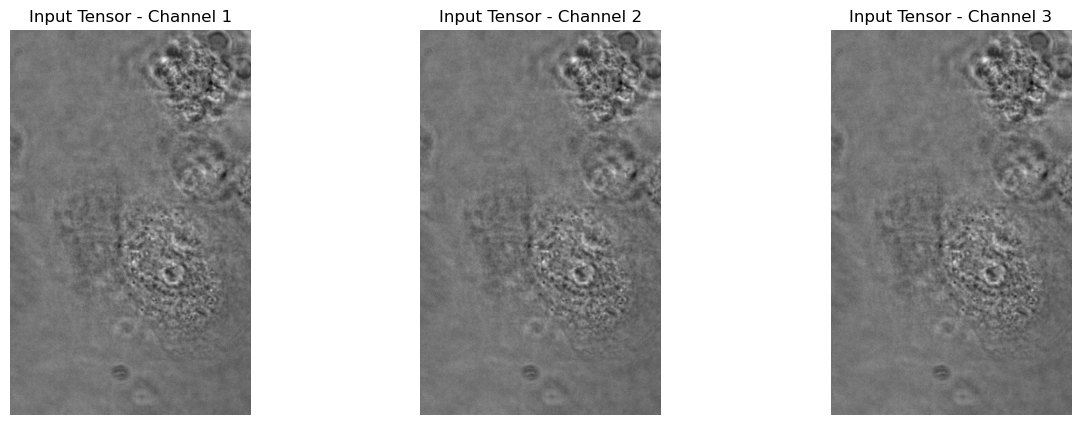

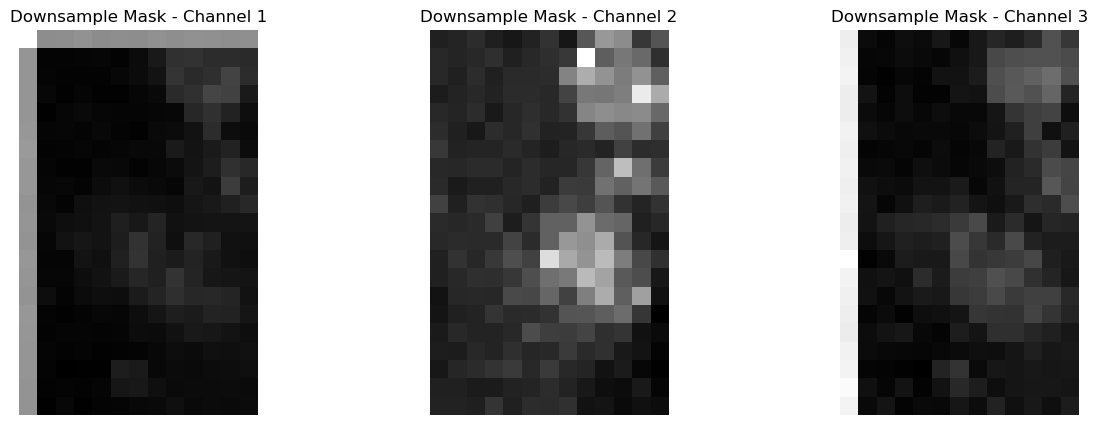

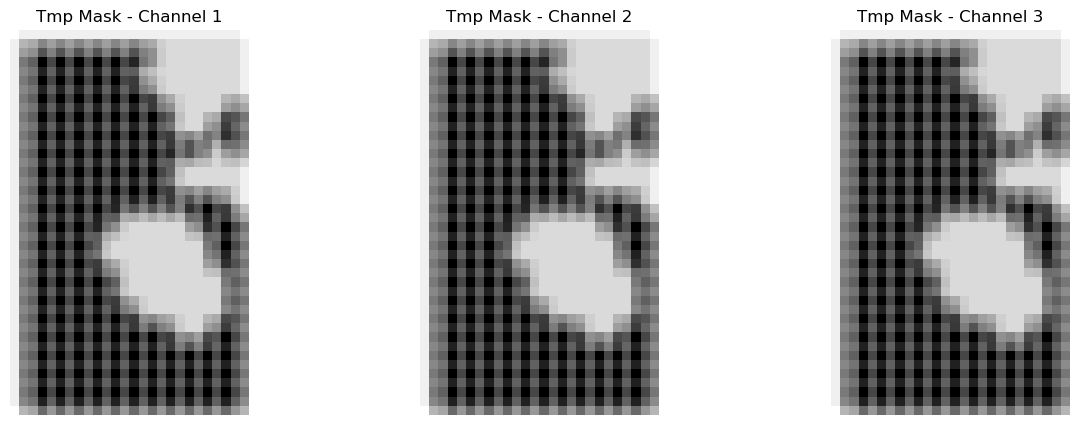

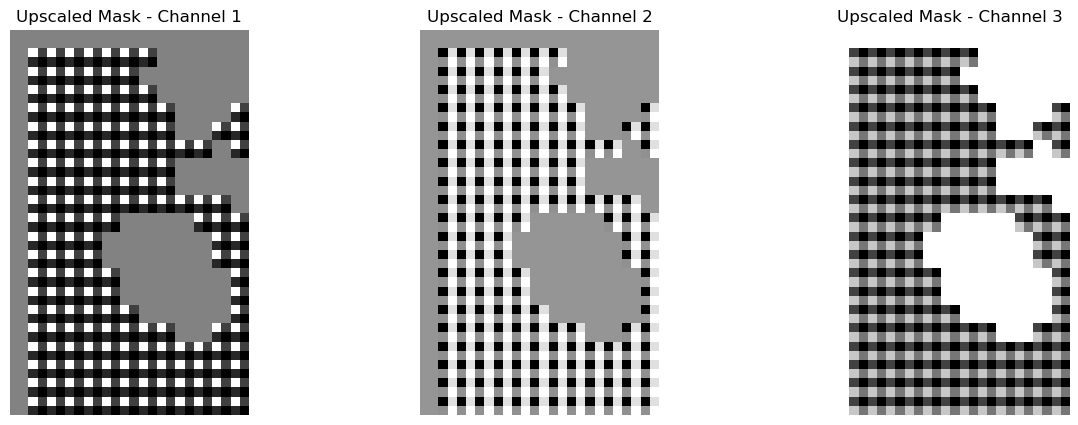

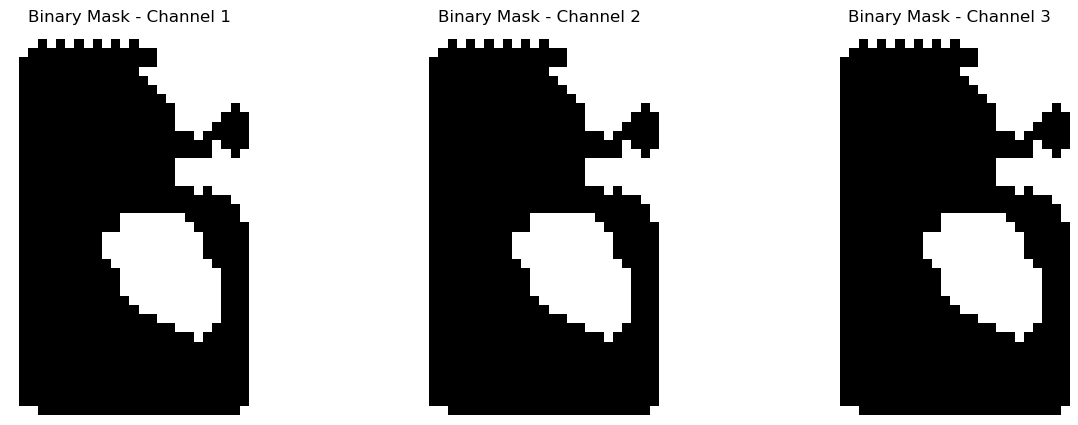

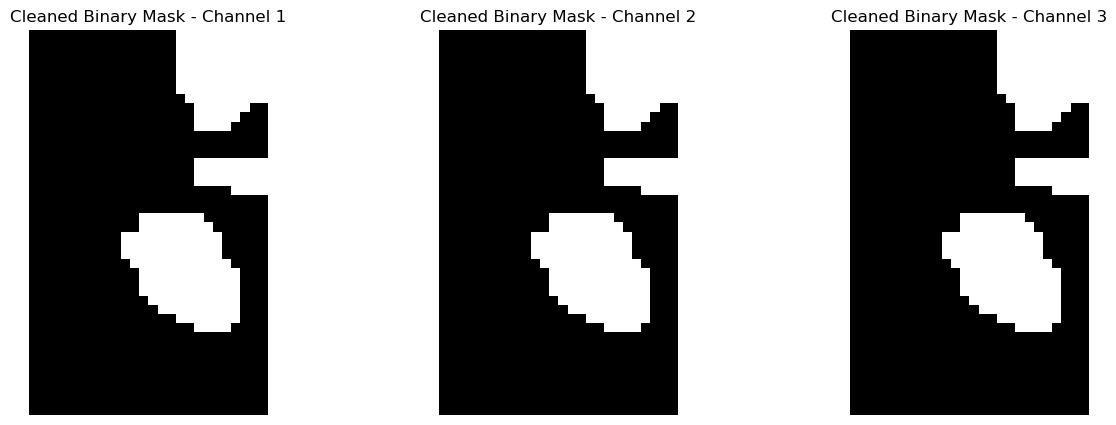

torch.Size([3, 42, 26])


In [19]:
# Assume `image_np` is your NumPy array of shape (height, width, 3)
# For example, let's create a random image for demonstration
image_np = gs_ndarray.astype(np.float32)

# Convert the NumPy array to a PyTorch tensor and add a batch dimension
input_tensor = torch.from_numpy(image_np).permute(2, 0, 1).unsqueeze(0)
in_channels = 3
out_channels = 32
show_model_values = True
# Instantiate the model
model = ROI_Generation_Layer(input_tensor.shape, in_channels, out_channels, -0.4)

cleaned_mask, binary_mask, smoothed_tensor = model(input_tensor)

print("\n")
print("Cleaned Mask Shape: ", cleaned_mask.shape," ", type(cleaned_mask))
print("Binary Mask Shape: ", binary_mask.shape," ", type(binary_mask))
print("Smoothed Mask Shape: ", smoothed_tensor.shape," ", type(smoothed_tensor))
print("\n")
model.plot_tensor_info()

if show_model_values:
    model.plot_masks(input_tensor)
else:
    # Call the function to plot the tensor channels
    plot_tensor_channels_3d(smoothed_tensor.squeeze(0), "Smooth-Channel")
    plot_tensor_channels_3d(cleaned_mask.squeeze(0), "Cleaned Mask")




print(cleaned_mask[0].shape)

## Use the classifier to get the zones in the image


In [50]:
print(cleaned_mask[0][0].shape)
print(cleaned_mask[0][0])

def get_combined_coordinates(mask):
    # Ensure the mask is a numpy array
    mask = np.array(mask)
    
    # Get coordinates of 1s
    coords_ones = np.argwhere(mask == 1)
    
    return coords_ones

points = get_combined_coordinates(cleaned_mask[0][0])

#print("Combined coordinates:")
#print(combined_coords)
print(points.shape)
# Extract X coordinates (all rows, first column)
x_coords = points[:, 0]

# Extract Y coordinates (all rows, second column)
y_coords = points[:, 1]



torch.Size([42, 26])
tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
(244, 2)
[ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  7  7
  7  7  7  7  7  7  7  8  8  8  8  8  8  9  9  9  9  9 10 10 10 10 14 14
 14 14 14 14 14 14 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16 17 17
 17 17 20 20 20 20 20 20 20 21 21 21 21 21 21 21 21 22 22 22 22 22 22 22
 22 22 22 22 23 23 23 23 23 23 23 23 23 23 23 24 24 24 24 24 24 24 24 24
 24 24 25 25 25 25 25 25 25 25 25 25 25 26 26 26 26 26 26 26 26 26 26 26
 27 27 27 27 27 27 27 27 27 27 27 28 28 28 28 28 28 28 28 28 28 28 29 29
 29 29 29 29 29 29 29 29 30 30 30 30 30 30 30 30 30 31 31 3

[[25.72131148 16.46721311]
 [ 4.06666667 20.52222222]
 [14.625      21.5       ]]


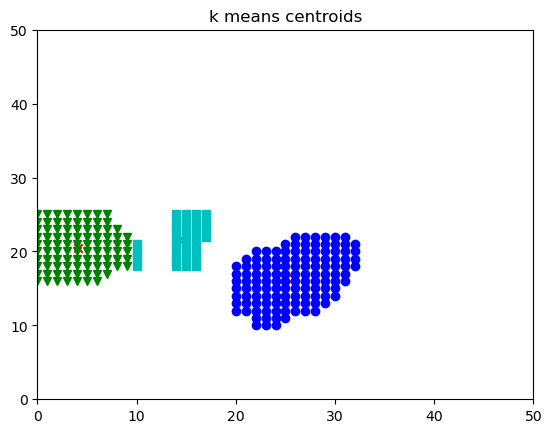

In [53]:
# clustering dataset
from sklearn.cluster import KMeans
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

x1 = points[:, 0]
x2 = points[:, 1]

# create new plot and data
plt.plot()
# X = np.array(list(zip(x1, x2))).reshape(len(x1), 2)
# print(X)
X = points
colors = ['b', 'g', 'c']
markers = ['o', 'v', 's']

# KMeans algorithm 
K = 3
kmeans_model = KMeans(n_clusters=K).fit(X)

print(kmeans_model.cluster_centers_)
centers = np.array(kmeans_model.cluster_centers_)

plt.plot()
plt.title('k means centroids')

for i, l in enumerate(kmeans_model.labels_):
    plt.plot(x1[i], x2[i], color=colors[l], marker=markers[l],ls='None')
    plt.xlim([0, 50])
    plt.ylim([0, 50])

plt.scatter(centers[:,0], centers[:,1], marker="x", color='r')
plt.show()